In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#seeding for comparing experiment in part 2
import torch
import json
SEED = 2017
SAMPLE_SEED = 2023
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:6')

# SNLI Bert
## Second Tutorial
https://towardsdatascience.com/fine-tuning-pre-trained-transformer-models-for-sentence-entailment-d87caf9ec9db
Check his Github code for complete notebook. I never referred to it. Medium was enough.
BERT in keras-tf: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [3]:
# define macros
BERT_MODEL = 'bert-base-german-cased'
batch_size = 4
batches_per_epoch = None

save_path_suffix = 'cotraining_baseline_de_en_allshuffle_de_labelset_balanceen2000_seededsampling_featureless_5_'

# Prepare data

## load the dataset

In [4]:
import pandas as pd

# custom reader needed to handle quotechars
def read_df_custom(file):
    header = 'doc     unit1_toks      unit2_toks      unit1_txt       unit2_txt       s1_toks s2_toks unit1_sent      unit2_sent      dir     nuc_children    sat_children    genre   u1_discontinuous        u2_discontinuous       u1_issent        u2_issent       u1_length       u2_length       length_ratio    u1_speaker      u2_speaker      same_speaker    u1_func u1_pos  u1_depdir       u2_func u2_pos  u2_depdir       doclen  u1_position      u2_position     percent_distance        distance        lex_overlap_words       lex_overlap_length      unit1_case      unit2_case      label'
    extracted_columns = ['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label', 'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case', 'unit2_case',
                            'u1_discontinuous', 'u2_discontinuous', 'same_speaker', 'lex_overlap_length', 'u1_func']
    header = header.split()
    df = pd.DataFrame(columns=extracted_columns)
    file = open(file, 'r')

    rows = []
    count = 0 
    for line in file:
        line = line[:-1].split('\t')
        count+=1
        if count ==1: continue
        row = {}
        for column in extracted_columns:
            index = header.index(column)
            try:
                row[column] = line[index]
            except:
                print(count, line)
            row[column] = line[index]
        rows.append(row)

    df = pd.concat([df, pd.DataFrame.from_records(rows)])
    return df

train_df_en = read_df_custom('../../processed/translated/eng.rst.rstdt_train_enriched_translated.rels')
test_df_en = read_df_custom('../../processed/translated/eng.rst.rstdt_test_enriched_translated.rels')
val_df_en = read_df_custom('../../processed/translated/eng.rst.rstdt_dev_enriched_translated.rels')
train_df_de = read_df_custom('../../processed/deu.rst.pcc_train_enriched.rels')
test_df_de = read_df_custom('../../processed/deu.rst.pcc_test_enriched.rels')
val_df_de = read_df_custom('../../processed/deu.rst.pcc_dev_enriched.rels')

lang='deu'

,target,aux_new_count
label,,
joint,201,538
elaboration,166,444
background,131,351
condition,99,265
cause,92,246
contrast,38,102
summary,6,16


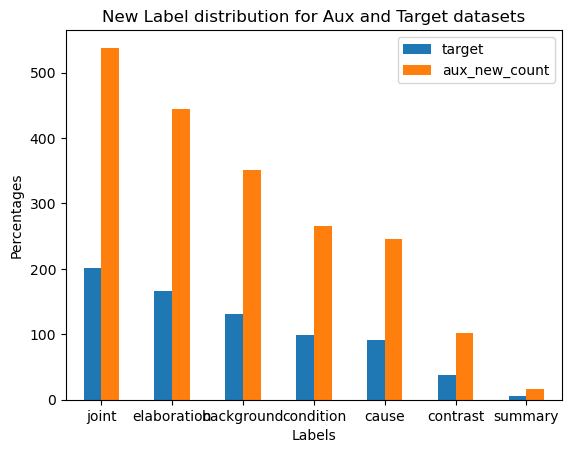

In [5]:
def dist_scaling(df_target, df_aux, plt=False):
    dist1 = df_target.groupby('label').count()['dir'].reset_index().rename(columns={"dir": "target"})
    dist1["target"] = dist1["target"]
    dist2 = df_aux.groupby('label').count()['dir'].reset_index().rename(columns={"dir": "aux"})
    j = pd.merge(dist1,dist2,on='label')
    j.sort_values(by=["target"], inplace=True, ascending=False)
    j.set_index('label', inplace=True)
    j['ratios'] = j["aux"]/j["target"]
    minimum_ratio = j['ratios'].min()
    j['aux_new'] = j['target']*minimum_ratio
    j['aux_new_count'] = j['aux_new'].round().astype(int)
    j = j[['target', 'aux_new_count']]

    if plt:
        ax = j.plot.bar(rot=0, title="New Label distribution for Aux and Target datasets")
        ax.set_xlabel("Labels")
        ax.set_ylabel("Percentages")
    return j

dist_scaling(train_df_de, train_df_en, plt=True)

In [6]:
import pandas as pd
from copy import deepcopy

data = pd.DataFrame({'cols1':[4, 5, 5, 4, 321, 32, 5, 40, 50, 60],
                     'cols2':[45, 66, 6, 6, 1, 432, 3, 40, 50, 60],
                     'label':['A', 'B', 'C', 'C', 'A', 'B', 'B', 'A', 'D', 'F']})

freq = pd.DataFrame({'label':['A', 'B', 'C', 'E'],
                     'nostoextract':[2, 2, 2, 30], })

def bootstrap(data, freq):
    data_labels = list(data['label'].unique())
    #drop the labels in freq that dont overlap
    freq_bak = freq.copy(deep=True)
    freq = freq[freq['label'].isin(data_labels)]

    #save the labels in data that dont overlap
    freq_labels = list(freq['label'].unique())
    extra_data = data[~data.label.isin(freq_labels)]

    #drop the labels in data that dont overlap
    data = data[data['label'].isin(freq_labels)]

    #bootstrap!
    freq = freq.set_index('label')

    def sampleClass(classgroup):
        cls = classgroup['label'].iloc[0]
        nDesired = freq.nostoextract[cls]
        nRows = len(classgroup)

        nSamples = min(nRows, nDesired)
        return classgroup.sample(nSamples, random_state=SAMPLE_SEED)

    samples = data.groupby('label').apply(sampleClass)
    samples.index = samples.index.get_level_values(1)

    #add back the extra samples
    samples = pd.concat([samples, extra_data])

    return samples

def get_distr(target_df, aux_df):
    '''this function takes the target distribution and multiplies it by constant. aux_new_count denotes the target's scaled distribution that needs to be applies on aux_df'''
    distr_combined = dist_scaling(target_df, aux_df)
    distr_aux_new = distr_combined[['aux_new_count']]
    distr_aux_new = distr_aux_new.rename(columns={"aux_new_count": "nostoextract"}).reset_index()
    return distr_aux_new

In [7]:
def process_labels_and_merge_evaluation_for_german(df):
    for delete_label in ['attribution', 'comparison', 'explanation', 'enablement', 'temporal', 'textual-organization', 'topic-change', 'topic-comment']:
        df = df[df.label != delete_label]
    df['label'] = df['label'].str.replace("manner-means", "means")
    df['label'] = df['label'].str.replace("evaluation-n", "evaluation")
    df['label'] = df['label'].str.replace("evaluation-s", "evaluation")
    return df

def balance_dataset(df, distribution_df):
    freq = get_distr(distribution_df, df)
    print('before')
    print(df.groupby('label').count()['dir'])
    df = bootstrap(df, freq)
    print('after')
    print(df.groupby('label').count()['dir'])
    return df

train_df_de = process_labels_and_merge_evaluation_for_german(train_df_de)
train_df_en = process_labels_and_merge_evaluation_for_german(train_df_en)
test_df = process_labels_and_merge_evaluation_for_german(test_df_de)
val_df = process_labels_and_merge_evaluation_for_german(val_df_de)

print(len(train_df_en))
train_df_en = balance_dataset(train_df_en, train_df_de)
print(len(train_df_en))

train_df = pd.concat([train_df_de, train_df_en])
train_df = train_df.sample(frac=1).reset_index(drop=True)

11430
before
label
background      711
cause           563
condition       265
contrast        875
elaboration    6454
evaluation      459
joint          1749
means           183
summary         171
Name: dir, dtype: int64
after
label
background     351
cause          246
condition      265
contrast       102
elaboration    444
evaluation     228
joint          538
means           21
summary         16
Name: dir, dtype: int64
2211


In [8]:
train_df['nuc_children'].astype(int).sum()

12998

In [9]:
def get_batches_per_epoch(train_df, batch_size=4):
    size = len(train_df)
    if size%batch_size!=0:
        return int(size/batch_size)+1
    else:
        return int(size/batch_size)

batches_per_epoch = get_batches_per_epoch(train_df, batch_size)
print(batches_per_epoch*batch_size, len(train_df), batches_per_epoch)

4376 4375 1094


## Clean the data

In [10]:
#dropping any empty values
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Prepare a dataset handler class

In [11]:
train_df.head()

,unit1_txt,unit1_sent,unit2_txt,unit2_sent,dir,label,distance,u1_depdir,u2_depdir,u2_func,...,sat_children,nuc_children,genre,unit1_case,unit2_case,u1_discontinuous,u2_discontinuous,same_speaker,lex_overlap_length,u1_func
0,"sondern das Wie , der Druck auf Abgeordnete ,","Nicht , dass beide eine Mehrheit für ihre Koal...",Wie hat das Bismarck einmal formuliert ?,Wie hat das Bismarck einmal formuliert ?,1<2,interpretation,12,LEFT,ROOT,root,...,1,8,news,title,cap_initial,False,False,True,1,conj
1,"er wird mehr von dem haben müssen , was Giersb...",Sein Nachfolger wird nicht allein am Kunstsinn...,"Sinn für das Geld - und damit für alle "" niede...",Sein Nachfolger wird nicht allein am Kunstsinn...,1<2,joint,1,LEFT,LEFT,appos,...,0,3,news,other,cap_initial,False,False,True,0,nsubj:pass
2,"Der "" Berufemarkt "" - erstmals in der Aula der...","Der "" Berufemarkt "" - erstmals in der Aula der...",Das hat allein das Interesse der Schülerinnen ...,Das hat allein das Interesse der Schülerinnen ...,1<2,reason,1,ROOT,ROOT,root,...,0,2,news,cap_initial,cap_initial,False,False,True,0,root
3,Leitzins :,Rate : 10 1 / 2 %.,Der Basiszinssatz für Firmenkredite an großen ...,Der Basiszinssatz für Firmenkredite an großen ...,1<2,elaboration,2,ROOT,ROOT,root,...,0,16,news,cap_initial,cap_initial,False,False,True,0,root
4,Die Verwaltung hat inzwischen beschwichtigend ...,Die Verwaltung hat inzwischen beschwichtigend ...,Doch sind 80 Unterschriften der Wille der Bewo...,Doch sind 80 Unterschriften der Wille der Bewo...,1>2,antithesis,1,ROOT,ROOT,root,...,0,3,news,cap_initial,cap_initial,False,False,True,1,root


In [12]:
train_df.columns

Index(['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label',
       'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position',
       'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case',
       'unit2_case', 'u1_discontinuous', 'u2_discontinuous', 'same_speaker',
       'lex_overlap_length', 'u1_func'],
      dtype='object')

# feats

In [13]:
from multiprocessing.sharedctypes import Value
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
from sys import path
path.append('/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/allennlp/data/data_loaders/')
from allennlp.data import allennlp_collate, Vocabulary
from features_custom_original import get_vocab_feature_name
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertTokenizer

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df):
    self.lang = lang
    self.num_labels = set()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.train_idx = None
    self.val_idx = None
    self.test_idx = None
    self.vocab = Vocabulary(counter=None, max_vocab_size=100000)
    self.init_data()

  def init_data(self):
    self.get_label_mapping()
    self.init_feature_list()
    self.init_feature_mappings_and_bins()
    self.apply_bins()
    self.calculate_unique_values()
    self.train_data, self.train_idx = self.load_data(self.train_df)
    self.val_data, self.val_idx = self.load_data(self.val_df)
    self.test_data, self.test_idx = self.load_data(self.test_df)
    

  def combine_unique_column_values_to_dict(self, column_name):
    ini_set = set([*self.train_df[column_name].unique(), *self.val_df[column_name].unique()])
    res = dict.fromkeys(ini_set, 0)
    return res

  def get_label_mapping(self):
    labels = {}
    labels_list = list(set(list(self.train_df['label'].unique()) + list(self.test_df['label'].unique()) + list(self.val_df['label'].unique())))
    for i in range(len(labels_list)):
        labels[labels_list[i]] = i
    self.label_dict = labels
    # needed later for classification report object to generate precision and recall on test dataset
    self.rev_label_dict = {self.label_dict[k]:k for k in self.label_dict.keys()} 

  def init_feature_mappings_and_bins(self):
    self.feature_maps = { 'genre': self.combine_unique_column_values_to_dict('genre'),
                          'unit1_case': self.combine_unique_column_values_to_dict('unit1_case'),
                          'unit2_case': self.combine_unique_column_values_to_dict('unit2_case'),
                          'u1_func': self.combine_unique_column_values_to_dict('u1_func'),
                          'u2_func': self.combine_unique_column_values_to_dict('u2_func') }

    self.bins = {
      'distance': [[-1e9, -8], [-8, -2], [-2, 0], [0, 2], [2, 8], [8, 1e9]],
      'u1_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'u2_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'lex_overlap_length': [[0, 2], [2, 7], [7, 1e9]]
    }   

  def add_directionality(self, premise, hypothesis, dir):
    if dir == "1<2":
        hypothesis = '< ' + hypothesis + ' {'
    else:
        premise = '} ' + premise + ' >'
    return premise, hypothesis

  def init_feature_list(self):
    if self.lang=='nld':
      self.feature_list = ['distance', 'u1_depdir', 'sat_children', 'genre', 'u1_position']
    elif self.lang=='deu':
      self.feature_list = []
    elif self.lang=='eng.rst.gum':
      self.feature_list = ['distance', 'same_speaker', 'u2_func', 'u2_depdir', 'unit1_case', 'unit2_case', 'nuc_children',
                      'sat_children', 'genre', 'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'u1_position', 'u2_position']
    elif self.lang=='fas':
      self.feature_list = ['distance', 'nuc_children', 'sat_children', 'u2_discontinuous', 'genre']
    elif self.lang=='spa.rst.sctb':
      self.feature_list = ['distance', 'u1_position', 'sat_children']
    elif self.lang=='zho.rst.sctb':
      self.feature_list = ['sat_children', 'nuc_children', 'genre', 'u2_discontinuous', 'u1_discontinuous', 'u1_depdir', 'u1_func']
    else: 
      raise ValueError()

  def get_mapping_from_dictionary(self, column_name, dict_val):
    return self.feature_maps[column_name][dict_val]

  def get_allen_features_list(self, features, feature_name):
    if feature_name in ['distance', 'u1_depdir', 'u2_depdir', 'u1_func', 'u2_func', 
    'u1_position', 'u2_position', 'genre', 'same_speaker', 'unit1_case', 'unit2_case',
    'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'dir']: feature_value = self.apply_vocab(features[feature_name], feature_name) #for categorical values
    elif feature_name in ['sat_children', 'nuc_children']: feature_value = float(features[feature_name]) #for identiy values
    else: 
      print(feature_name)
      raise ValueError()
    return feature_value

  def transform_feature(self, features):
    assert len(features)==17
    #after applying the vocab. we need to pass them as int
    return {feature_name: torch.tensor(int(self.get_allen_features_list(features, feature_name))).to(device) for feature_name in self.feature_list+['dir']}

  def calculate_unique_values(self):
    for feature_name in self.feature_list+['dir']:
      vocab_feature_name = get_vocab_feature_name(feature_name)
      self.vocab.add_tokens_to_namespace(train_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)
      self.vocab.add_tokens_to_namespace(val_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)

  def apply_bins(self):
    for df in [self.train_df, self.test_df, self.val_df]:
      for feature_name in self.bins.keys():
        if feature_name=='u2_func':
          print(df[feature_name].unique())
          raise ValueError()
        df[feature_name] = df[feature_name].apply(lambda x: self.get_mapping_from_bin(feature_name, float(x)))

  def get_mapping_from_bin(self, column_name, dict_val):
    bins = self.bins[column_name]
    for b,i in zip(bins, range(len(bins))):
      left = b[0]
      right = b[1]
      if left<=dict_val and right>=dict_val: return i

  def apply_vocab(self, feature_value, feature_name):
    return self.vocab.get_token_index(str(feature_value), namespace=get_vocab_feature_name(feature_name))

  def set_labels(self):
    self.num_labels = len(self.num_labels)
    
  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    # seg_ids = []
    y = []
    feats = []
    idx = []
    idx_map = {}

    self.num_labels.update(df['label'].unique())

    count=0
    for row in df.iterrows():
      row = row[1]
      premise = row['unit1_txt']
      hypothesis = row['unit2_txt']
      label = row['label']
      dir = row['dir']

      features = {'distance': row['distance'],
                'u1_depdir': row['u1_depdir'],
                'u2_depdir': row['u2_depdir'],
                'u1_func': row['u1_func'],
                'u2_func': row['u2_func'],
                'u1_position': row['u1_position'],
                'u2_position': row['u2_position'],
                'sat_children': row['sat_children'],
                'nuc_children': row['nuc_children'],
                'genre': row['genre'],
                'unit1_case': row['unit1_case'],
                'unit2_case': row['unit2_case'],
                'u1_discontinuous': row['u1_discontinuous'],
                'u2_discontinuous': row['u2_discontinuous'],
                'same_speaker': row['same_speaker'],
                'lex_overlap_length': row['lex_overlap_length'],
                'dir': row['dir']}

      premise, hypothesis = self.add_directionality(premise, hypothesis, dir)
      encoded = self.tokenizer.encode_plus(premise, hypothesis, add_special_tokens = True, max_length=MAX_LEN, truncation=True, padding=False) #padding='max_length'
      pair_token_ids = torch.tensor(encoded['input_ids'])

      # segment_ids = torch.tensor(encoded['token_type_ids'])
      attention_mask_ids = torch.tensor(encoded['attention_mask'])
      assert len(pair_token_ids)==len(attention_mask_ids)

      features = self.transform_feature(features)

      token_ids.append(pair_token_ids)
      # seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
      feats.append(features)
      
      idx_map[count] = [premise, hypothesis]
      idx.append(count)
      count+=1
      
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    # seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    idx = torch.tensor(idx)

    class featureDataset(Dataset):
      def __init__(self, token_ids, mask_ids, feats, y, idx):
          self.token_ids = token_ids
          self.mask_ids = mask_ids
          # self.seg_ids = seg_ids
          self.feats = feats
          self.y = y
          self.idx = idx

      def __len__(self):
          return len(self.feats)

      def __getitem__(self, idx):
          return self.token_ids[idx], self.mask_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]
          # return self.token_ids[idx], self.mask_ids[idx], self.seg_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]

    # dataset = featureDataset(token_ids, mask_ids, seg_ids, feats, y, idx)
    dataset = featureDataset(token_ids, mask_ids, feats, y, idx)
    return dataset, idx_map

  def get_data_loaders(self, batch_size=4, batches_per_epoch=402, shuffle=True): #1609 samples / 64:25=1600 / 402:4=1608
    self.set_labels()
    train_loader_torch = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    val_loader_torch = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    test_loader_torch = DataLoader(
      self.test_data,
      shuffle=False,
      batch_size=batch_size,
    )
    
    train_loader = LoaderWrapper(train_loader_torch, n_step=batches_per_epoch)
    val_loader = LoaderWrapper(val_loader_torch, n_step=batches_per_epoch)
    test_loader = LoaderWrapper(test_loader_torch, n_step=batches_per_epoch)

    return train_loader, val_loader_torch, test_loader_torch

2023-03-15 11:18:21.946050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 11:18:22.250302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-10.2/targets/x86_64-linux/lib/:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/home/VD/kaveri/anaconda3/envs/py310/lib/
2023-03-15 11:18:22.250335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not hav

In [14]:
class LoaderWrapper:
    def __init__(self, loader, n_step):
        self.step = n_step
        self.idx = 0
        self.iter_loader = iter(loader)
        self.loader = loader
    
    def __iter__(self):
        return self

    def __len__(self):
        return self.step

    def __next__(self):
        # if reached number of steps desired, stop
        if self.idx == self.step:
            self.idx = 0
            raise StopIteration
        else:
            self.idx += 1
        # while True
        try:
            return next(self.iter_loader)
        except StopIteration:
            # reinstate iter_loader, then continue
            self.iter_loader = iter(self.loader)
            return next(self.iter_loader)

### Mnliloader

In [15]:
mnli_dataset = MNLIDataBert(train_df, val_df, test_df)
mnli_dataset_en = MNLIDataBert(train_df_en, val_df_en, test_df_en) #to apply bins because df passed by reference

train_loader, val_loader, test_loader = mnli_dataset.get_data_loaders(batch_size=batch_size, batches_per_epoch=batches_per_epoch) #64X250
label_dict = mnli_dataset.label_dict # required by custom func to calculate accuracy, bert model
rev_label_dict = mnli_dataset.rev_label_dict # required by custom func to calculate accuracy

In [16]:
for feature in mnli_dataset.feature_list:
    vocab_feature_name = get_vocab_feature_name(feature)
    print(feature, ': ', mnli_dataset.vocab.get_token_to_index_vocabulary(vocab_feature_name))
    mnli_dataset.vocab.add_tokens_to_namespace(val_df_en[feature].apply(lambda x: str(x)), namespace=vocab_feature_name)
    print(feature, ': ', mnli_dataset.vocab.get_token_to_index_vocabulary(vocab_feature_name))
print('dir', ': ', mnli_dataset.vocab.get_token_to_index_vocabulary('dir'))

dir :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '1<2': 2, '1>2': 3}


In [17]:
for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(train_loader):
    assert len(feat)==len(mnli_dataset.feature_list)+1

# Define the model

## load pretrained model

In [18]:
from transformers import BertForSequenceClassification, AdamW
from torch import optim
import os
path.append(os.path.join(os.getcwd(), '../utils/'))
from CategoricalAccuracy import CategoricalAccuracy as CA
import numpy as np

ca = CA()

x = torch.tensor(np.array([[[1,0,0], [1,0,0], [1,0,0]]]))
y1 = torch.tensor(np.array([[0], [1], [1]]))
y2 = torch.tensor(np.array([[0], [0], [0]]))

ca(x,y1)
print(ca.get_metric(reset=True))
ca(x,y2)
print(ca.get_metric(reset=True))

0.3333333333333333
1.0


## define evaulation metric

In [19]:
# to evaluate model for train and test. And also use classification report for testing
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# helper function to calculate the batch accuracy
def multi_acc(y_pred, y_test, allennlp=False):
  if allennlp==False:
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

# freeze model weights and measure validation / test 
def evaluate_accuracy(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset.val_idx if is_training else mnli_dataset.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      # seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      
      outputs = model(pair_token_ids, 
                            # token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      acc = multi_acc(outputs, labels)

      total_val_loss += loss.item()
      total_val_acc  += acc.item()

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        premise_list.append(idx_map[i][0])
        hypo_list.append(idx_map[i][1])

  val_acc  = total_val_acc/len(data_loader)
  val_loss = total_val_loss/len(data_loader)
  cr = classification_report(y_true, y_pred)

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}
  
  return val_acc, val_loss, cr, model, optimizer, idx_json

## define custom bert model

In [20]:
import copy
from typing import Any, Dict, Optional
from transformers import BertModel, BertConfig
import torch.nn as nn
from tensorflow.keras.layers import TimeDistributed
from featurefulbertembedder_custom_allennlp_dims import FeaturefulBertEmbedder
from featureful_bert_custom_allennlp_dims import get_combined_feature_tensor_2 as get_combined_feature_tensor_forward
from features_custom_allennlp_dims import get_feature_modules

class CustomPooler2(nn.Module):
    def __init__(self, *,
                        requires_grad: bool = True,
                        dropout: float = 0.0,
                        transformer_kwargs: Optional[Dict[str, Any]] = None, ) -> None:
        super().__init__()
        bert = BertModel.from_pretrained(BERT_MODEL) #only used to pass config. BertAttentionClass used in FeatureFulBert
        self._dropout = torch.nn.Dropout(p=dropout)
        self.pooler = copy.deepcopy(bert.pooler)
        for param in self.pooler.parameters():
            param.requires_grad = requires_grad
        self._embedding_dim = bert.config.hidden_size

    def get_input_dim(self) -> int:
        return self._embedding_dim

    def get_output_dim(self) -> int:
        return self._embedding_dim

    def forward(self, tokens: torch.Tensor, mask: torch.BoolTensor = None, num_wrapping_dims: int = 0):
        pooler = self.pooler
        
        for _ in range(num_wrapping_dims):
            pooler = TimeDistributed(pooler)
        pooled = pooler(tokens)
        pooled = self._dropout(pooled)
        return pooled

class MyModule(nn.Module):    
    def __init__(self, feature_list):
        super(MyModule, self).__init__()
        self.feature_list = feature_list
        self.feature_modules = nn.ModuleDict()
        self.dims = 0
        self.feature_modules, dims = get_feature_modules(feature_list, mnli_dataset.vocab, use_allennlp_dims=True)
        self.dims += dims

        print(self.feature_modules)
        for feature in feature_list:
            if feature not in ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 
                                'nuc_children', 'sat_children']: raise ValueError()
            # elif 'genre' in feature_list:               self.modules['genre'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'unit1_case' in feature_list:          self.modules['unit1_case'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'unit2_case' in feature_list:          self.modules['unit2_case'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u1_discontinuous' in feature_list:    self.modules['u1_discontinuous'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u2_discontinuous' in feature_list:    self.modules['u2_discontinuous'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'same_speaker' in feature_list:        self.modules['same_speaker'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'lex_overlap_length' in feature_list:  self.modules['lex_overlap_length'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)
            # elif 'u1_func' in feature_list:             self.modules['u1_func'] = nn.Embedding(mnli_dataset_en.distance_unique, 3)

    def forward(self, features):
        feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
        for i in range(len(feature_list)):
            feature_name = feature_list[i]
            feature_modules = self.feature_modules[feature_name]
            feature = features[...,i]
            if feature_name not in ['sat_children', 'nuc_children']:
                if torch.max(feature)>feature_modules.num_embeddings:
                    print(feature_name, feature)
                    raise ValueError()

        return get_combined_feature_tensor_forward(features, self.feature_list, self.feature_modules)

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
          super(CustomBERTModel, self).__init__()
          self.num_classes = num_labels
          self.feature_list = mnli_dataset.feature_list
          print('ASSIGN:', self.num_classes)

          self.embedder = self.create_featureful_bert() #BERT MODEL
          self.encoder = CustomPooler2()
          self.module1 = MyModule(self.feature_list)
          self.dropout1 = nn.Dropout(p=0.0)
        #   self.dropout_decoder = nn.Dropout(p=0.5)
          self.out_features = self.encoder.pooler.dense.out_features+self.module1.dims
          self.relation_decoder = nn.Linear(self.out_features, self.num_classes)

    def forward(self, pair_token_ids, attention_mask, feat):
        direction_tensor = feat['dir'].to(device)
        embedded_sentence = self.embedder(token_ids=pair_token_ids, #featurefulmebedder
                        mask=attention_mask, 
                        # type_ids=token_type_ids,
                        segment_concat_mask = None,
                        direction_tensor = direction_tensor,
                        feature_list = self.feature_list,
                        features = feat)
        # mask = token_type_ids
        bertpooler_output = self.encoder(tokens=embedded_sentence, mask=None)
                #feat = self.convert_to_feature_list(feat)
        #feat = self.dropout1(feat)
        #feat = self.module1(feat)
        # try:
        #     feat_concat = torch.concat((bertpooler_output, feat),-1)
        # except:
        #     print(bertpooler_output.shape, feat.shape)
        #     raise ValueError()
        # if feat_concat.shape[-1]!=self.module1.dims+bertpooler_output.shape[-1]: print(feat_concat.shape, self.module1.dims)
        # assert feat_concat.shape[-1] == self.module1.dims+bertpooler_output.shape[-1]
        # feat_concat = self.dropout1(feat_concat)
        feat_concat = bertpooler_output
        linear1_output = self.relation_decoder(feat_concat)
        return linear1_output


    def create_featureful_bert(self):
        featureful_bert = FeaturefulBertEmbedder(model_name = BERT_MODEL,
                                hidden_activation_allen = 'gelu',
                                feature_list = self.feature_list, 
                                vocab=mnli_dataset.vocab,
                                use_allen_dims=True)
        return featureful_bert

    def convert_to_feature_list(self, feat):
        feature_linear = [feat[feature_name] for feature_name in self.feature_list]
        feature_linear = torch.stack(feature_linear, dim=-1)
        return feature_linear

model = CustomBERTModel(mnli_dataset.num_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False) # original 2e-5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, mode='max', patience=35, min_lr=5e-7, verbose=True) #original factor=0.6, min_lr=5e-7

ASSIGN: 25


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing FeaturefulBert: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing FeaturefulBert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FeaturefulBert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.d

ModuleDict()


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## define training regime

### prinintg model

In [21]:
print(model)

CustomBERTModel(
  (embedder): FeaturefulBertEmbedder(
    (transformer_model): FeaturefulBert(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [22]:
from torch.utils.tensorboard import SummaryWriter

def writer_init(save_path_suffix):
    writer_path = 'run1/'+save_path_suffix[:-1]+'/'
    if os.path.isdir(writer_path):
        filelist = [ f for f in os.listdir(writer_path) if 'events.out' in f ]
        print(filelist)
        for f in filelist:
            os.remove(os.path.join(writer_path, f))
    else:
        os.mkdir(writer_path)
    writer = SummaryWriter(log_dir=writer_path)
    return writer

writer = writer_init(save_path_suffix)

In [23]:
import time
import traceback
import torch.nn.functional as F

from typing import Optional, Iterable, Dict, Any
from EarlyStopperUtil import MetricTracker
from sklearn.metrics import classification_report

EPOCHS = 100

def train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict):  
  EarlyStopper = MetricTracker(patience=20, metric_name='+accuracy')
  best_val_acc = 0


  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    
    # logging for scheduler
    losses = []
    accuracies= []

    train_size = 0

    for batch_idx, (pair_token_ids, mask_ids, feat, y, idx) in enumerate(train_loader):
      train_size+=1
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      # seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      outputs = model(pair_token_ids = pair_token_ids, 
                            # token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      loss.backward()
      acc = multi_acc(outputs, labels)
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      losses.append(loss)
      accuracies.append(acc)
      
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    val_acc, val_loss, cr, model, optimizer, idx_json = evaluate_accuracy(model, optimizer, val_loader, rev_label_dict, label_dict, None)
    if val_acc>best_val_acc:
      torch.save(model.state_dict(), 'run1/'+save_path_suffix+'_best.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    if val_acc>=best_val_acc:
      torch.save(model.state_dict(), 'run1/'+save_path_suffix+'_best_latest.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    EarlyStopper.add_metric(val_acc)
    if EarlyStopper.should_stop_early(): break

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f'train_size: {train_size}')

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_acc', val_acc, epoch)



### train

In [24]:
import warnings
from sklearn.exceptions import DataConversionWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict)

Epoch 1: Best val_acc: 0.1844
Epoch 1: Best val_acc: 0.1844
Epoch 1: train_loss: 2.4914 train_acc: 0.2554 | val_loss: 2.6491 val_acc: 0.1844
00:03:23.24
train_size: 1094
Epoch 2: Best val_acc: 0.2377
Epoch 2: Best val_acc: 0.2377
Epoch 2: train_loss: 2.1367 train_acc: 0.3488 | val_loss: 2.4741 val_acc: 0.2377
00:03:25.01
train_size: 1094
Epoch 3: train_loss: 1.9601 train_acc: 0.3977 | val_loss: 2.3711 val_acc: 0.2295
00:03:31.17
train_size: 1094
Epoch 4: Best val_acc: 0.2582
Epoch 4: Best val_acc: 0.2582
Epoch 4: train_loss: 1.8101 train_acc: 0.4536 | val_loss: 2.3504 val_acc: 0.2582
00:03:26.97
train_size: 1094
Epoch 5: Best val_acc: 0.3115
Epoch 5: Best val_acc: 0.3115
Epoch 5: train_loss: 1.6777 train_acc: 0.5042 | val_loss: 2.2606 val_acc: 0.3115
00:03:29.52
train_size: 1094
Epoch 6: train_loss: 1.5469 train_acc: 0.5508 | val_loss: 2.2694 val_acc: 0.3033
00:03:36.16
train_size: 1094
Epoch 7: Best val_acc: 0.3115
Epoch 7: train_loss: 1.4127 train_acc: 0.5963 | val_loss: 2.2453 val_a

# test

### latest

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMet

Test_loss: 3.9955 test_acc: 0.2769
00:00:02.20
                precision    recall  f1-score   support

    antithesis       0.30      0.17      0.21        18
    background       0.15      0.12      0.13        17
         cause       0.29      1.00      0.44         2
  circumstance       0.29      0.40      0.33        15
    concession       0.35      0.54      0.42        13
     condition       0.54      0.78      0.64         9
   conjunction       0.30      0.43      0.35         7
      contrast       0.12      0.12      0.12         8
 e-elaboration       0.55      0.55      0.55        11
   elaboration       0.12      0.20      0.15        10
    evaluation       0.43      0.15      0.22        20
      evidence       0.21      0.30      0.25        10
interpretation       0.05      0.08      0.06        12
         joint       0.24      0.31      0.27        29
          list       0.23      0.12      0.15        26
         means       1.00      0.50      0.67         2


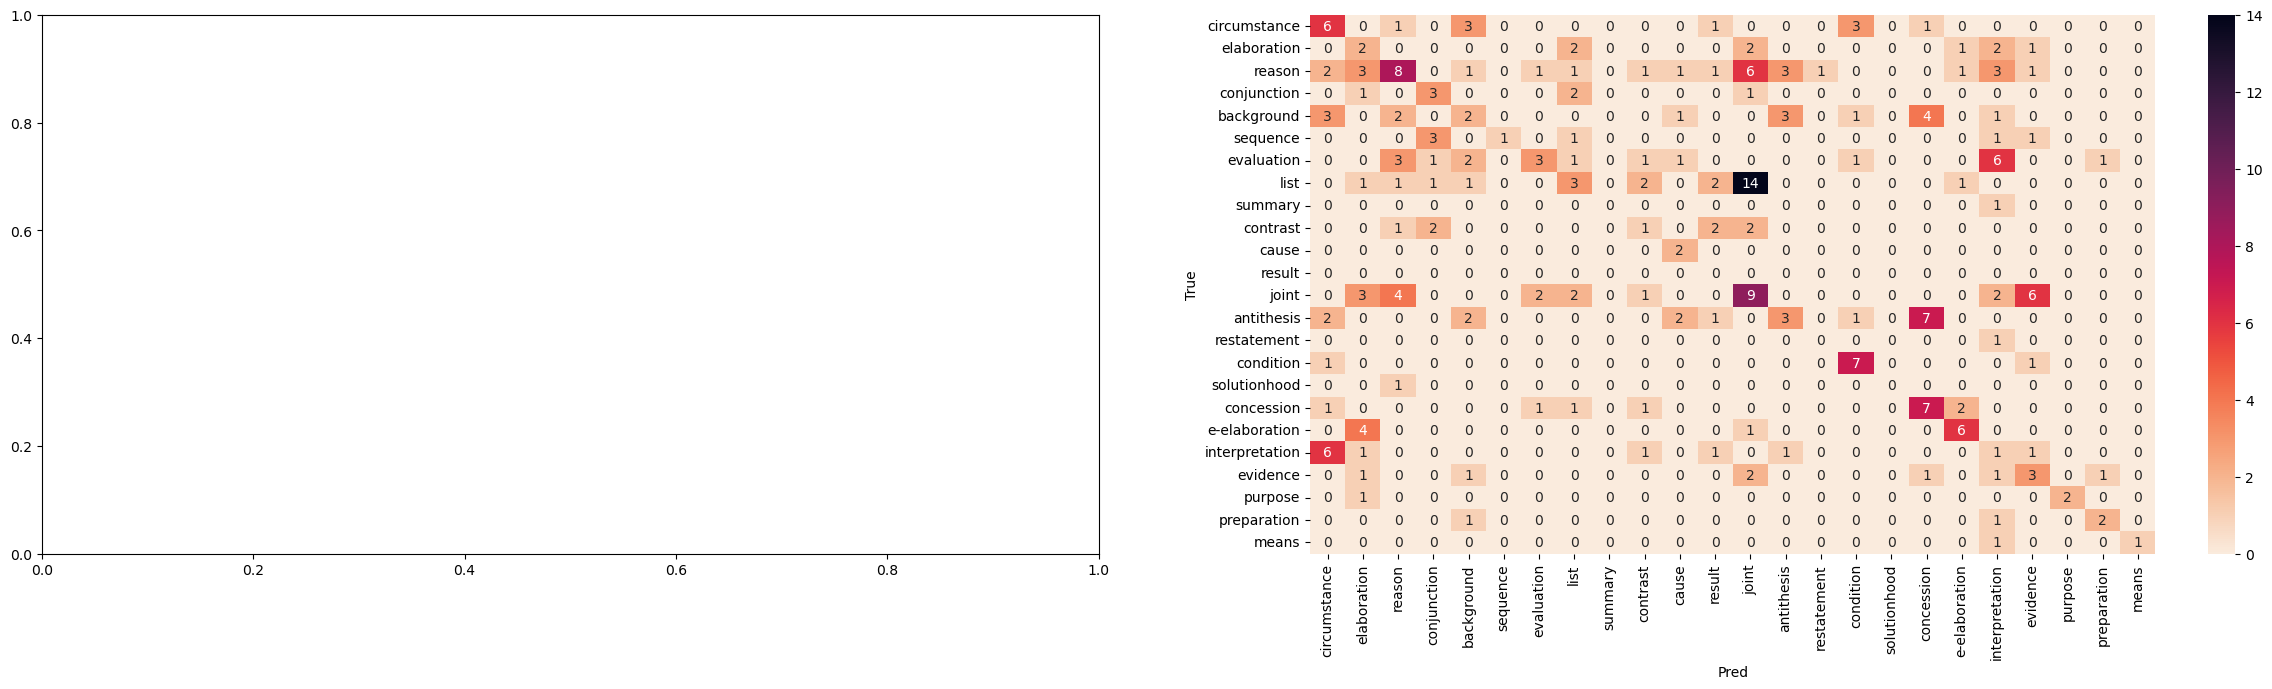

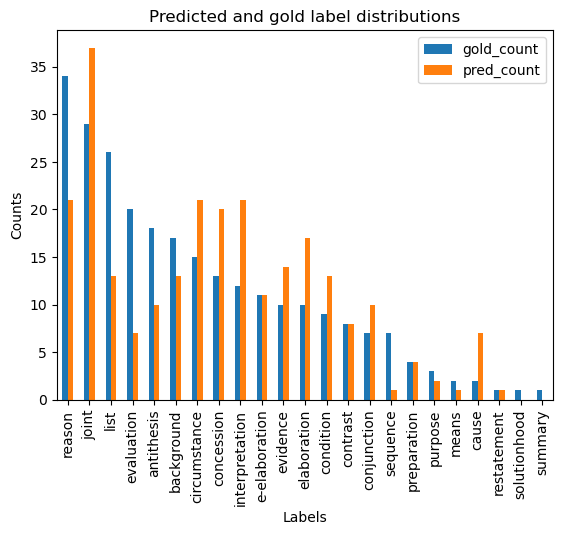

Test Loss: 3.996 |  Test Acc: 27.69%


In [25]:
from sklearn.metrics import confusion_matrix

def validate(model, test_loader, optimizer, rev_label_dict, label_dict):
  start = time.time()
  test_acc, test_loss, cr, model, optimizer, idx_json = evaluate_accuracy(model, optimizer, test_loader, rev_label_dict, label_dict, is_training=False)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print(cr)

  labels = list(set(idx_json['gold_label'])|set(idx_json['pred_label']))
  cm = confusion_matrix(idx_json['gold_label'], idx_json['pred_label'], labels=labels)

  fig, ax = plt.subplots(1, 2, figsize=(30, 7))
  ax[1] = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='.4g',cmap = sns.cm.rocket_r)
  ax[1].set_xlabel('Pred') 
  ax[1].set_ylabel('True')

  df_perf = pd.DataFrame()
  df_perf['gold_label'] = idx_json['gold_label']
  df_perf['pred_label'] = idx_json['pred_label']

  df_stats = pd.DataFrame()
  df_stats['gold_count'] = df_perf.groupby('gold_label').count()
  df_stats['pred_count'] = df_perf.groupby('pred_label').count()
  df_stats.fillna(0, inplace=True)
  df_stats.sort_values(by=["gold_count"], inplace=True, ascending=False)

  ax[0] = df_stats.plot.bar(rot=90, title="Predicted and gold label distributions")
  ax[0].set_xlabel("Labels")
  ax[0].set_ylabel("Counts")

  plt.show()

  return test_loss, test_acc, idx_json


test_loss, test_acc, idx_json = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_latest', test_loss, 1)
writer.add_scalar('test_acc_latest', test_acc, 1)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

### best earliest

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 2.8597 test_acc: 0.2731
00:00:02.18
                precision    recall  f1-score   support

    antithesis       0.29      0.11      0.16        18
    background       0.14      0.12      0.13        17
         cause       0.20      1.00      0.33         2
  circumstance       0.25      0.33      0.29        15
    concession       0.39      0.54      0.45        13
     condition       0.41      0.78      0.54         9
   conjunction       0.33      0.43      0.38         7
      contrast       0.00      0.00      0.00         8
 e-elaboration       0.45      0.45      0.45        11
   elaboration       0.14      0.20      0.17        10
    evaluation       0.29      0.10      0.15        20
      evidence       0.33      0.20      0.25        10
interpretation       0.05      0.08      0.06        12
         joint       0.23      0.41      0.30        29
          list       0.17      0.12      0.14        26
         means       0.00      0.00      0.00         2


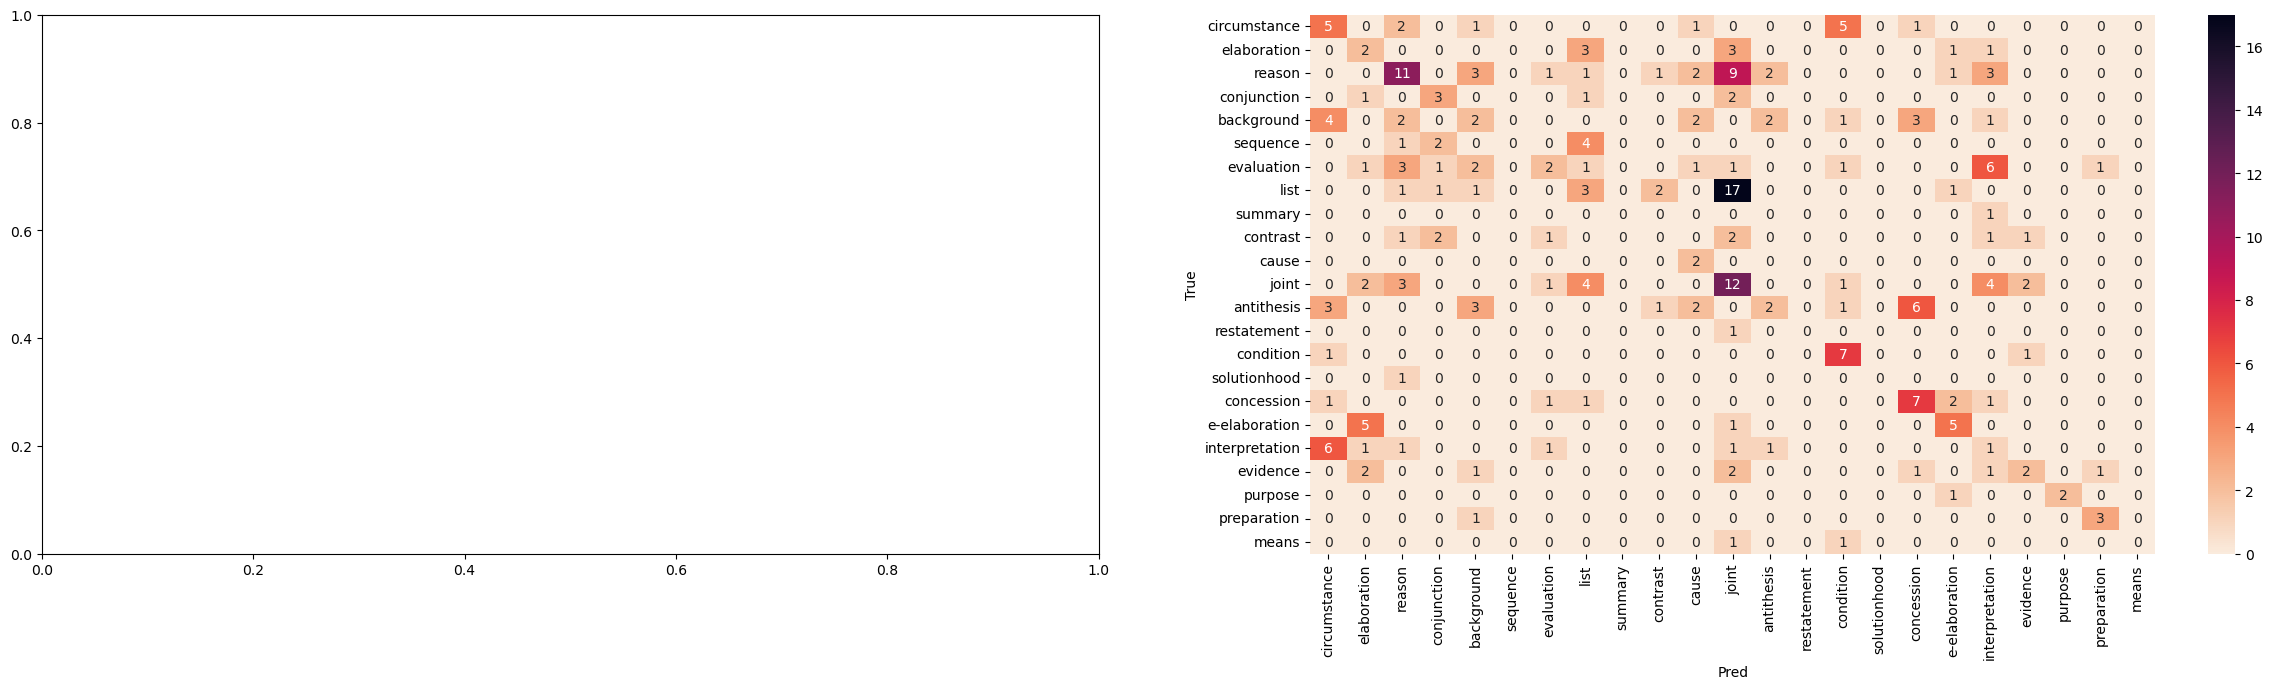

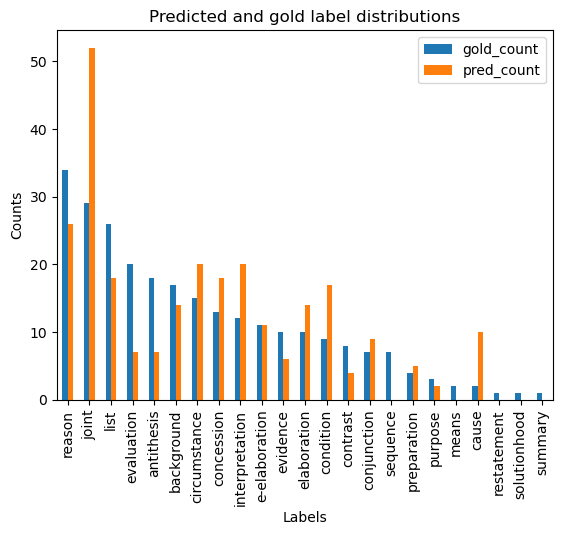

Latest Test Loss: 2.860 |  Latest Test Acc: 27.31%


In [26]:
model.load_state_dict(torch.load('run1/'+save_path_suffix+'_best.pt'))
test_loss, test_acc, idx_json = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

### best lastest

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 2.8597 test_acc: 0.2731
00:00:02.08
                precision    recall  f1-score   support

    antithesis       0.29      0.11      0.16        18
    background       0.14      0.12      0.13        17
         cause       0.20      1.00      0.33         2
  circumstance       0.25      0.33      0.29        15
    concession       0.39      0.54      0.45        13
     condition       0.41      0.78      0.54         9
   conjunction       0.33      0.43      0.38         7
      contrast       0.00      0.00      0.00         8
 e-elaboration       0.45      0.45      0.45        11
   elaboration       0.14      0.20      0.17        10
    evaluation       0.29      0.10      0.15        20
      evidence       0.33      0.20      0.25        10
interpretation       0.05      0.08      0.06        12
         joint       0.23      0.41      0.30        29
          list       0.17      0.12      0.14        26
         means       0.00      0.00      0.00         2


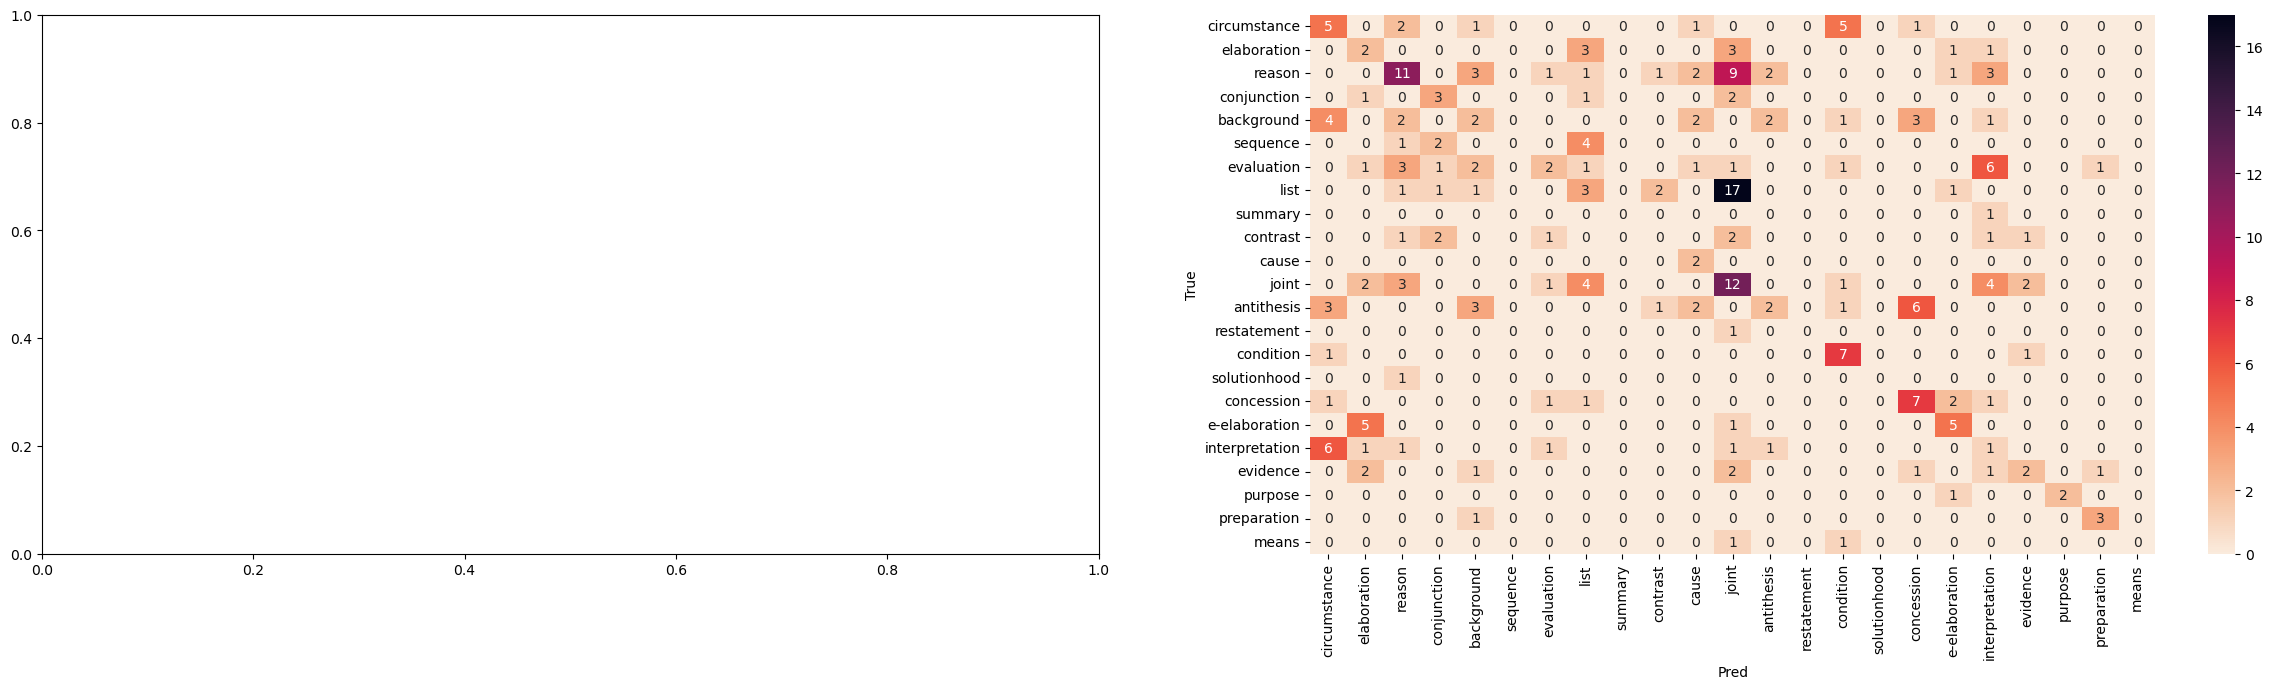

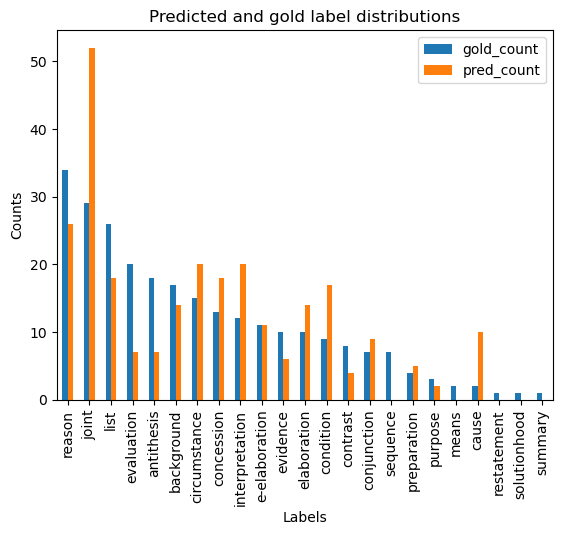

Best Test Loss: 2.860 |  Best Test Acc: 27.31%


In [27]:
model.load_state_dict(torch.load('run1/'+save_path_suffix+'_best_latest.pt'))
test_loss, test_acc, idx_json = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
json.dump(idx_json, open('run1/'+save_path_suffix+'_best_latest.json', 'w'))
writer.add_scalar('test_loss_best_latest', test_loss, 1)
writer.add_scalar('test_acc_best_latest', test_acc, 1)
print(f'Best Test Loss: {test_loss:.3f} |  Best Test Acc: {test_acc*100:.2f}%')

### best val

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: Unde

Test_loss: 2.5010 test_acc: 0.3525
00:00:01.79
                precision    recall  f1-score   support

    antithesis       0.38      0.27      0.32        11
    background       0.31      0.29      0.30        17
         cause       0.12      0.14      0.13         7
  circumstance       0.29      0.15      0.20        13
    concession       0.32      0.73      0.44        11
     condition       0.67      1.00      0.80         8
   conjunction       0.83      0.62      0.71         8
      contrast       0.00      0.00      0.00         3
 e-elaboration       0.70      0.54      0.61        13
   elaboration       0.30      0.21      0.25        28
    evaluation       0.00      0.00      0.00        13
      evidence       0.00      0.00      0.00         8
interpretation       0.15      0.23      0.18        13
         joint       0.24      0.44      0.31        18
          list       0.42      0.56      0.48        18
         means       0.00      0.00      0.00         1


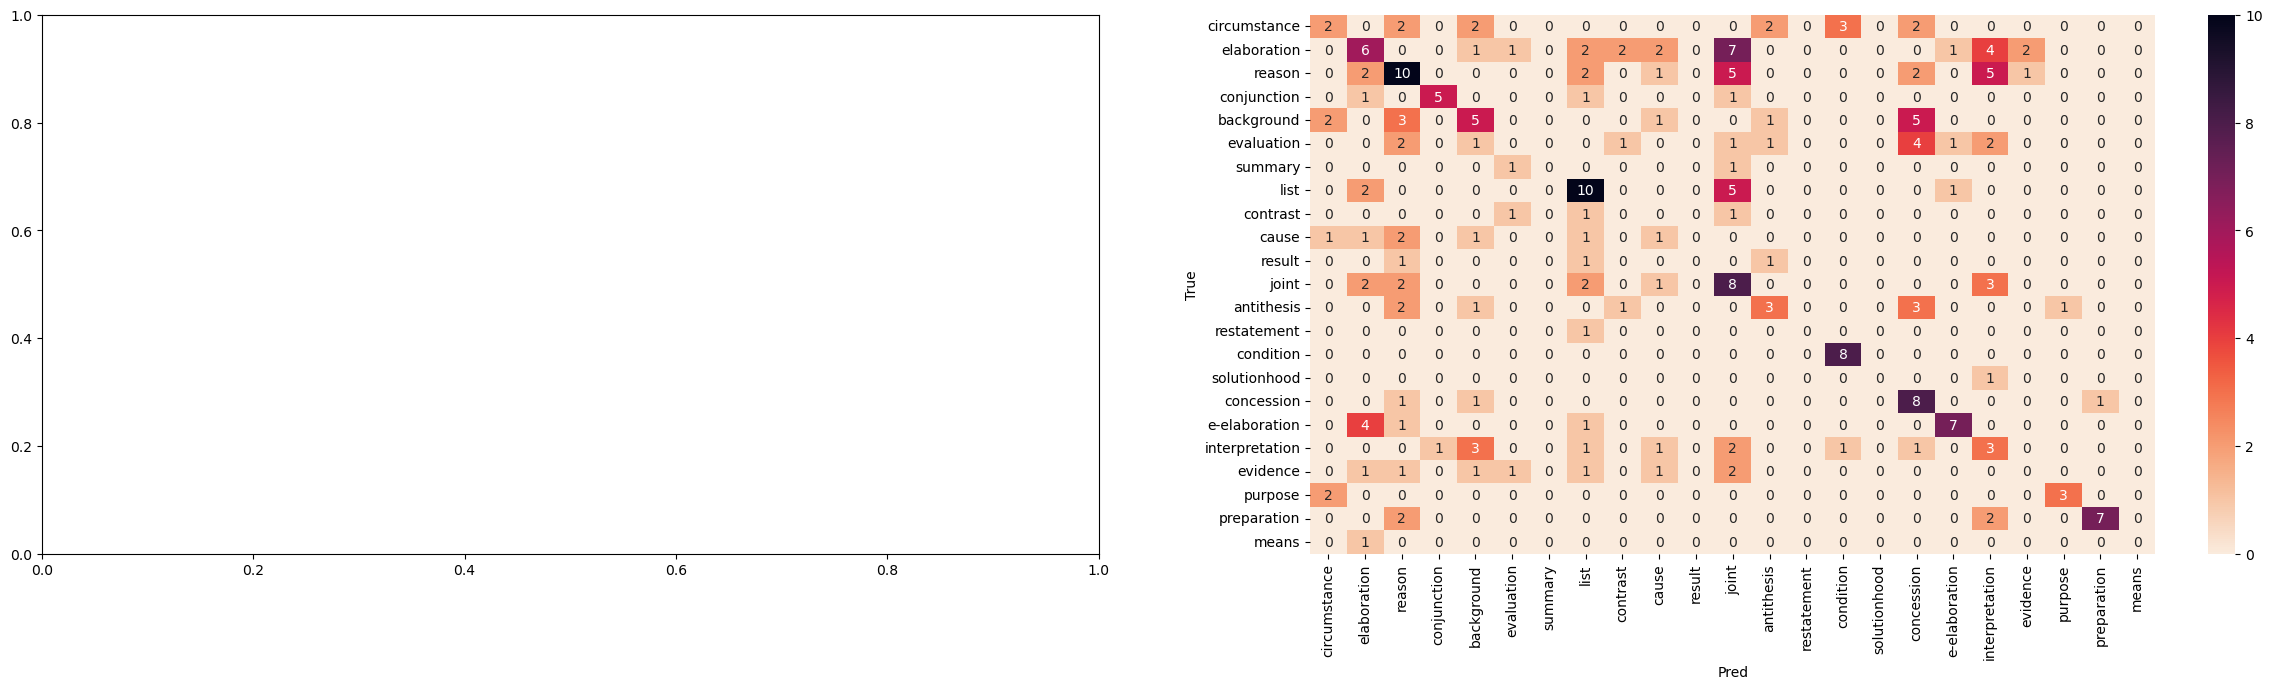

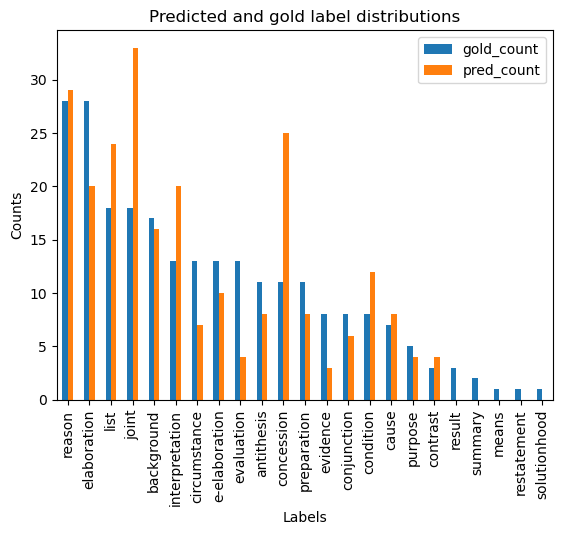

Val Loss: 2.501 |  Val Acc: 35.25%


In [28]:
model.load_state_dict(torch.load('run1/'+save_path_suffix+'_best_latest.pt'))
test_loss, test_acc, idx_json = validate(model, val_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')

In [29]:
train_df_en.groupby(['label']).count()

,unit1_txt,unit1_sent,unit2_txt,unit2_sent,dir,distance,u1_depdir,u2_depdir,u2_func,u1_position,...,sat_children,nuc_children,genre,unit1_case,unit2_case,u1_discontinuous,u2_discontinuous,same_speaker,lex_overlap_length,u1_func
label,,,,,,,,,,,,,,,,,,,,,
background,351,351,351,351,351,351,351,351,351,351,...,351,351,351,351,351,351,351,351,351,351
cause,246,246,246,246,246,246,246,246,246,246,...,246,246,246,246,246,246,246,246,246,246
condition,265,265,265,265,265,265,265,265,265,265,...,265,265,265,265,265,265,265,265,265,265
contrast,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
elaboration,444,444,444,444,444,444,444,444,444,444,...,444,444,444,444,444,444,444,444,444,444
evaluation,228,228,228,228,228,228,228,228,228,228,...,228,228,228,228,228,228,228,228,228,228
joint,538,538,538,538,538,538,538,538,538,538,...,538,538,538,538,538,538,538,538,538,538
means,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
summary,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
